In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
pd.options.display.float_format = '{:20,.2f}'.format

## Load

In [3]:
connection = sqlite3.connect('airbnb.db')
cursor = connection.cursor()

In [4]:
vwListings = pd.read_sql_query("SELECT * from most_recent_listings", connection)

In [5]:
connection.close()

## Transform

In [6]:
def price_to_numeric(df):
    df['price'] = df['price'].str.replace(',','',regex=False)
    df['price'] = df['price'].str.strip('$').astype('float')

In [7]:
price_to_numeric(vwListings)

## Drop

In [8]:
vwListings.drop(vwListings.loc[vwListings['price']==0].index, inplace=True)

In [9]:
vwListings.drop(vwListings.loc[vwListings['has_availability']=='f'].index, inplace=True)

In [10]:
vwListings['reviews_per_month'] = vwListings['reviews_per_month'].replace({'': 0})
vwListings.drop(vwListings.loc[vwListings['reviews_per_month'] > 31].index, inplace=True)

## Baseline Model

We would like to give our hosts recommendations on how to price their listing(s) on a given day. We want to recommend a price that is consistent with the prices of other listings. To make a recommendation, we predict the price based on past listing prices. 

We're indifferent between overestimates and underestimates. Both lead to decreased revenue for hosts, just in different ways: overestimates lead to fewer bookings, while underestimates leave money that could have been charged on the table. We'd also like to penalize large errors more than small errors. Therefore, we will use the mean as a null model since it minimizes mean squared error.

We calculate the mean price in our sample:

In [11]:
price = vwListings['price']
price_predict = round(price.mean(), 2)
price_predict

178.81

The Baseline Model predicts a price / day of 178.81.

To see if we can get an idea of the error bounds on this prediction, we calculate the price standard deviation.

In [12]:
round(vwListings['price'].std(), 2)

205.54

The standard deviation is 205.54. Price isn't close to normally distributed, so we can't use the standard deviation to put 95% probability bounds on this prediction. The standard deviation is also greater than the mean, so negative numbers are less than one standard deviation away from the prediction. Consequently, we can't even apply Chebyshev's inequality to the prediction.

In [13]:
mse = ((price - price_predict)**2).sum()/len(price)
print('sigma:', round(np.sqrt(mse), 2))

sigma: 205.53


Our loss function is mean squared error. Applying the Baseline Model to the data results in $\sigma = 205.53$.

## Distributional Model

In [14]:
from scipy.stats import norm, lognorm

### Log-Gaussian Distribution

We expect the relevant factors for determining price to generally have <i>multiplicative</i> rather than additive effects. For instance, consider which sort of effect is more plausible for the bedrooms in a listing:

<ol>
    <li>Each extra bedroom increases the price by 25%.</li>
    <li>Each extra bedroom increases the price by $50.</li>
</ol>

Option 1 makes more sense. An extra bedroom in a nice neighborhood is going to be worth more in absolute terms than an extra bedroom in a bad neighborhood.

Gaussian distributions are generally good models of the results of many small <i>additive</i> effects, but Log-Gaussian distributions are better models of the results of many small multiplicative effects. The two are related: if $Y$ has a Gaussian distribution, then $X = exp(Y)$ has a Log-Gaussian distribution.

We parameterize the distribution with the sigma parameter set to the standard deviation of $log(price)$ and the scale parameter set to $exp(\bar{log(price)})$.

In [15]:
mu = np.log(price).mean()
sigma = np.log(price).std()

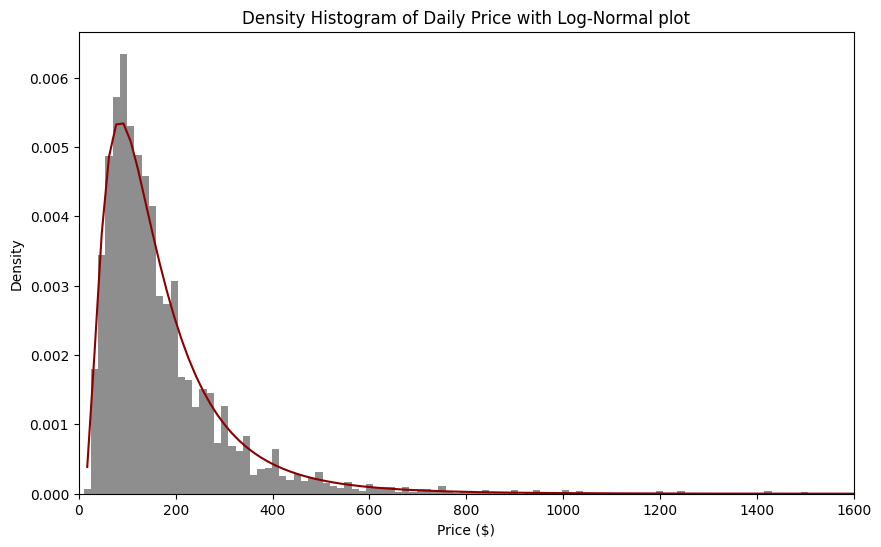

In [16]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(price, color="DimGray", density=True, bins=501, alpha=0.75) # 501
axes.set_xlabel("Price ($)")
axes.set_ylabel("Density")
axes.set_title("Density Histogram of Daily Price with Log-Normal plot")

axes.set_xlim(0,1600)

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [lognorm.pdf(k, s=sigma, scale=np.exp(mu)) for k in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

This seems like a pretty good model for the data, though there are some clear weaknesses. It overestimates the probability of very small pricees and underestimates the probability of prices around 100 and extremely high prices.

We compare the cumulative distributions to get a better idea of the strengths and weaknesses of the model.

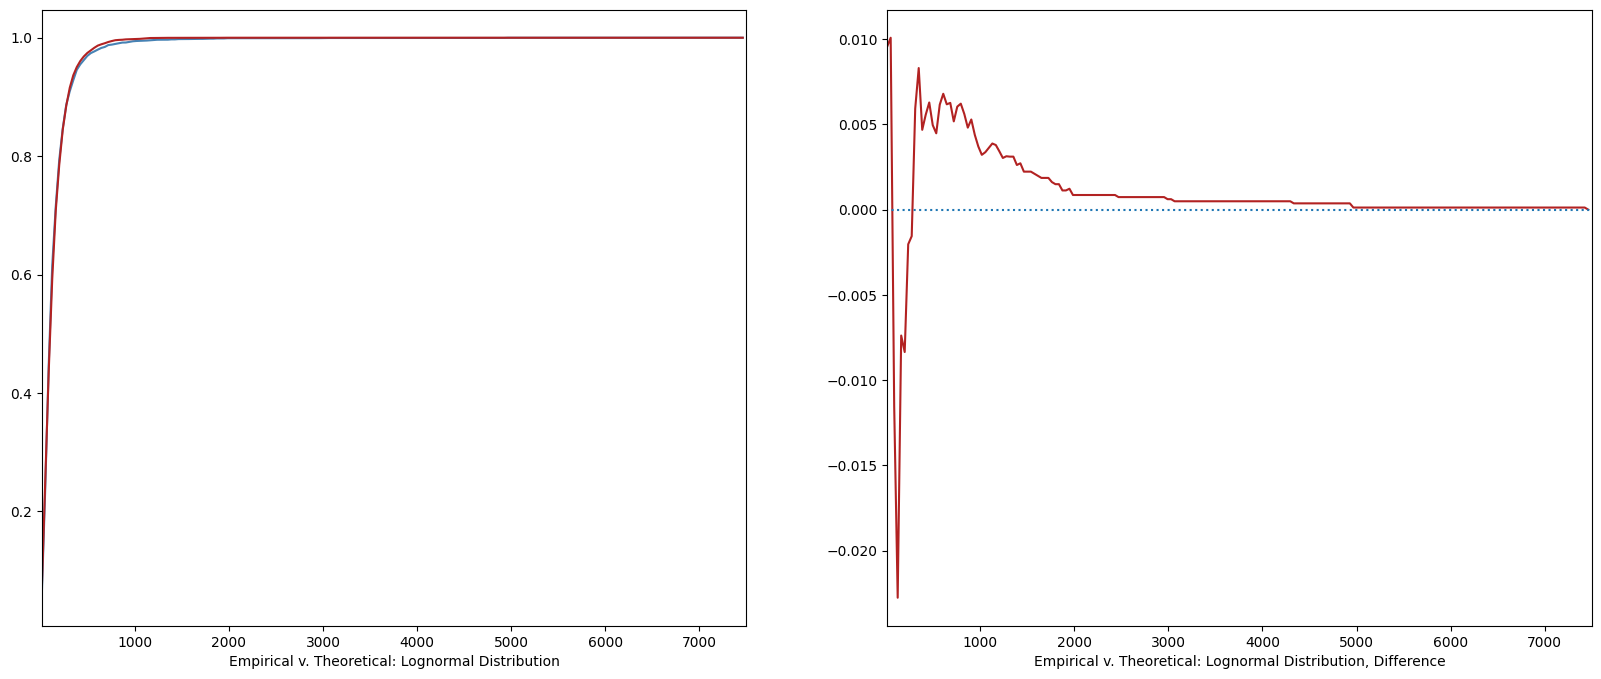

In [17]:
figure = plt.figure(figsize=(20, 8))

price_mn = np.min(price)
price_mx = np.max(price)
mean = np.mean(price)
std = np.std(price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(price, bins=201, density=True)
cumulative = np.cumsum(values*(base[1:] - base[:-1]))
axes.plot(base[:-1], cumulative, color="steelblue")
axes.set_xlim((price_mn, price_mx))

values2, base2 = np.histogram(lognorm.rvs(s=sigma, loc=0, scale=np.exp(mu), size=10000), bins=base, density=True)
cumulative2 = np.cumsum(values2*(base2[1:] - base2[:-1]))
axes.plot(base[:-1], cumulative2, color="firebrick")
axes.set_xlim((price_mn, price_mx))
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
axes.set_xlim((price_mn, price_mx))
axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel("Empirical v. Theoretical: Lognormal Distribution, Difference")

plt.show()
plt.close()

The model clearly overestimates probabilities at some points and underestimates at others, but overall its cumulative distribution is generally less than 1 percentage point away from the empirical distribution. The main weakness is around price 100.

### Predictions

We first ask the model for the probability of a relatively low price below $100.

In [18]:
lognorm.cdf(100, s=sigma, scale=np.exp(mu))

0.32538837269752796

There is a 32.5% probability of paying less than $100 / night.

What about a very high price? What is the probability of paying over $750 / night?

In [19]:
1 - lognorm.cdf(750, s=sigma, scale=np.exp(mu))

0.006704520101207145

There is only a 0.7% probability of paying over $750 / night.

Finally, what about an intermediate price? The model seems weakest around $100 and slightly above, so what probability does it assign there?

In [20]:
lognorm.cdf(250, s=sigma, scale=np.exp(mu)) - lognorm.cdf(100, s=sigma, scale=np.exp(mu))

0.4845480447282067

Though the model tends to underestimate the empirical distribution in this range, there is still a 48.5% probability of price between 100 and 250.